<a href="https://colab.research.google.com/github/RDGopal/IB9AU-2026/blob/main/MLM7_Diffusion_Financial_Document_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Financial Document Generation with Diffusion

CONTEXT: PRIVACY-PRESERVING SYNTHETIC DATA
In FinTech, we often cannot train OCR (Optical Character Recognition) models
on real client invoices due to GDPR/PII regulations.

SOLUTION:
We train a Diffusion model on the *structure* of invoices (layout, lines, headers)
but without real text. We then use these 'hallucinated' documents to pre-train
OCR systems or stress-test fraud detection pipelines.

GOAL:
Train a Conditional Diffusion Model that can generate:
- Class 0: Invoices (Grid structure)
- Class 1: Receipts (List structure)
- Class 2: Charts (Visual structure)
"""

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random
from PIL import Image, ImageDraw

In [ ]:
# ==========================================
# 2. INTERNAL UTILITIES (Data Generator)
# ==========================================
# We define the generator here so the notebook is self-contained.

def create_financial_document(doc_type=None, size=(64, 64)):
    """Generates a low-res synthetic financial document."""
    w, h = size
    img = Image.new('L', size, color=255) # White background
    draw = ImageDraw.Draw(img)

    if doc_type is None:
        doc_type = random.choice(['invoice', 'receipt', 'chart'])

    if doc_type == 'invoice':
        # Header block
        draw.rectangle([2, 2, w//3, 10], fill=200) # Logo
        draw.rectangle([w//3 + 4, 4, w-5, 8], fill=0) # Title
        # Grid Lines
        margin = 5
        line_height = (h - 20) // 5
        start_y = 15
        for i in range(5):
            y = start_y + i * line_height
            draw.line([margin, y, w-margin, y], fill=180, width=1)
            draw.rectangle([margin, y+2, margin+10, y+line_height-2], fill=100) # Item
            draw.rectangle([w-20, y+2, w-margin, y+line_height-2], fill=100) # Price
        # Total
        draw.rectangle([w-25, h-10, w-5, h-4], fill=0)

    elif doc_type == 'receipt':
        # Narrower content, centered
        margin = w // 4
        # Shop Header
        draw.rectangle([margin, 2, w-margin, 8], fill=0)
        # List of items
        for y in range(12, h-15, 4):
            draw.line([margin, y, margin + 10, y], fill=50, width=1) # Item
            draw.line([w-margin-10, y, w-margin, y], fill=50, width=1) # Price
        # Divider & Total
        draw.line([margin, h-12, w-margin, h-12], fill=0, width=1)
        draw.rectangle([margin+5, h-10, w-margin-5, h-4], fill=0)

    elif doc_type == 'chart':
        # Axes
        draw.line([5, 5, 5, h-5], fill=0, width=1)
        draw.line([5, h-5, w-5, h-5], fill=0, width=1)
        # Random Bar or Line
        if random.random() > 0.5:
            bar_w = (w - 10) // 6
            for i in range(5):
                height = random.randint(5, h-10)
                x = 10 + i * bar_w
                draw.rectangle([x, h-5-height, x+bar_w-2, h-5], fill=150)
        else:
            points = []
            for i in range(6):
                x = 5 + i * ((w-10)//5)
                y = h - 5 - random.randint(5, h-15)
                points.append((x, y))
            draw.line(points, fill=0, width=2)
    return img

class FinancialDataset(torch.utils.data.Dataset):
    def __init__(self, num_samples=1000, size=(64, 64), transform=None):
        self.num_samples = num_samples
        self.size = size
        self.transform = transform
        self.data = []
        self.labels = []

        # Pre-generate data
        print(f"Synthesizing {num_samples} documents...")
        for _ in range(num_samples):
            label_str = random.choice(['invoice', 'receipt', 'chart'])
            img = create_financial_document(label_str, size)
            label_map = {'invoice': 0, 'receipt': 1, 'chart': 2}
            self.data.append(img)
            self.labels.append(label_map[label_str])

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label


In [ ]:
# ==========================================
# 3. CONFIGURATION & MODEL
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

HPARAMS = {
    "img_size": 64,
    "timesteps": 500,
    "batch_size": 32,
    "lr": 3e-4,
    "epochs": 10,
    "channels": 1,
    "num_classes": 3
}

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = np.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()

    def forward(self, x, t):
        h = self.bnorm1(self.relu(self.conv1(x)))
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[(..., ) + (None, ) * 2]
        h = h + time_emb
        h = self.bnorm2(self.relu(self.conv2(h)))
        return self.transform(h)

class ConditionalUNet(nn.Module):
    def __init__(self):
        super().__init__()
        img_channels = HPARAMS["channels"]
        down_channels = (32, 64, 128)
        up_channels = (128, 64, 32)
        out_dim = img_channels
        time_emb_dim = 32
        classes = HPARAMS["num_classes"]

        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )
        self.class_emb = nn.Embedding(classes, time_emb_dim)
        self.conv0 = nn.Conv2d(img_channels, down_channels[0], 3, padding=1)
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], time_emb_dim) for i in range(len(down_channels)-1)])
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], time_emb_dim, up=True) for i in range(len(up_channels)-1)])
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep, class_label):
        t = self.time_mlp(timestep)
        c = self.class_emb(class_label)
        t = t + c
        x = self.conv0(x)
        residuals = []
        for down in self.downs:
            x = down(x, t)
            residuals.append(x)
        for up in self.ups:
            residual = residuals.pop()
            x = torch.cat((x, residual), dim=1)
            x = up(x, t)
        return self.output(x)


In [ ]:
# ==========================================
# 4. TRAINING & SAMPLING
# ==========================================
class DiffusionManager:
    def __init__(self, timesteps=500, start=0.0001, end=0.02):
        self.timesteps = timesteps
        self.betas = torch.linspace(start, end, timesteps).to(device)
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)

    def forward_noise(self, x_0, t):
        noise = torch.randn_like(x_0)
        sqrt_alpha_bar_t = self.sqrt_alphas_cumprod[t][:, None, None, None]
        sqrt_one_minus_alpha_bar_t = self.sqrt_one_minus_alphas_cumprod[t][:, None, None, None]
        return sqrt_alpha_bar_t * x_0 + sqrt_one_minus_alpha_bar_t * noise, noise

    @torch.no_grad()
    def sample(self, model, n_samples, class_label_idx, size):
        model.eval()
        x = torch.randn((n_samples, 1, size, size)).to(device)
        labels = torch.full((n_samples,), class_label_idx, dtype=torch.long).to(device)
        for i in reversed(range(1, self.timesteps)):
            t = (torch.ones(n_samples) * i).long().to(device)
            predicted_noise = model(x, t, labels)
            alpha = self.alphas[t][:, None, None, None]
            alpha_hat = self.alphas_cumprod[t][:, None, None, None]
            beta = self.betas[t][:, None, None, None]
            if i > 1:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)
            x = (1 / torch.sqrt(alpha)) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        model.train()
        return x

def train():
    # 1. Prepare Data
    dataset = FinancialDataset(num_samples=2000, size=(HPARAMS["img_size"], HPARAMS["img_size"]), transform=transforms.ToTensor())
    dataloader = DataLoader(dataset, batch_size=HPARAMS["batch_size"], shuffle=True)

    # 2. Initialize
    model = ConditionalUNet().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=HPARAMS["lr"])
    diffusion = DiffusionManager(timesteps=HPARAMS["timesteps"])
    loss_fn = nn.MSELoss()

    print(f"Starting training for {HPARAMS['epochs']} epochs...")
    for epoch in range(HPARAMS['epochs']):
        pbar = tqdm(dataloader)
        epoch_loss = 0
        for step, (images, labels) in enumerate(pbar):
            images = images.to(device)
            labels = labels.to(device)
            t = torch.randint(0, HPARAMS["timesteps"], (images.shape[0],), device=device).long()
            x_noisy, noise = diffusion.forward_noise(images, t)
            noise_pred = model(x_noisy, t, labels)
            loss = loss_fn(noise_pred, noise)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            pbar.set_description(f"Epoch {epoch} | Loss: {loss.item():.4f}")
    return model, diffusion

def visualize_results(model, diffusion):
    print("\nGenerating Class 0 (Invoices)...")
    invoices = diffusion.sample(model, 4, 0, HPARAMS["img_size"])
    print("Generating Class 1 (Receipts)...")
    receipts = diffusion.sample(model, 4, 1, HPARAMS["img_size"])
    print("Generating Class 2 (Charts)...")
    charts = diffusion.sample(model, 4, 2, HPARAMS["img_size"])

    all_images = torch.cat([invoices, receipts, charts], dim=0)
    grid = make_grid(all_images, nrow=4, padding=2, normalize=True)
    plt.figure(figsize=(10, 8))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy(), cmap='gray')
    plt.title("Generated: Invoices (Top), Receipts (Mid), Charts (Bot)")
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    trained_model, diff_manager = train()
    visualize_results(trained_model, diff_manager)

In [ ]:
# ==========================================
# 5. SAVE & LOAD UTILITIES (NEW)
# ==========================================

def save_model(model, filename="fintech_diffusion_model.pth"):
    """Saves model weights to disk."""
    torch.save(model.state_dict(), filename)
    print(f"✅ Model saved to {filename}")

def load_model(filename="fintech_diffusion_model.pth"):
    """Creates a new model instance and loads weights."""
    if not os.path.exists(filename):
        print(f"❌ Error: {filename} not found.")
        return None

    model = ConditionalUNet().to(device)
    model.load_state_dict(torch.load(filename, map_location=device))
    model.eval()
    print(f"✅ Model loaded from {filename}")
    return model

def generate_single_document(model, diffusion, doc_type='invoice'):
    """Generates a single image of the requested type."""
    label_map = {'invoice': 0, 'receipt': 1, 'chart': 2}

    if doc_type not in label_map:
        print(f"❌ Unknown type: {doc_type}. Use 'invoice', 'receipt', or 'chart'")
        return

    print(f"🎨 Generating new {doc_type}...")
    sample_tensor = diffusion.sample(model, n_samples=1, class_label_idx=label_map[doc_type], size=HPARAMS["img_size"])

    # Convert tensor to displayable image
    img = sample_tensor[0].cpu().permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min()) # Normalize to 0-1

    plt.figure(figsize=(4,4))
    plt.imshow(img, cmap='gray')
    plt.title(f"Generated {doc_type.capitalize()}")
    plt.axis('off')
    plt.show()

def visualize_results(model, diffusion):
    print("\nGenerating Grid of Samples...")
    invoices = diffusion.sample(model, 4, 0, HPARAMS["img_size"])
    receipts = diffusion.sample(model, 4, 1, HPARAMS["img_size"])
    charts = diffusion.sample(model, 4, 2, HPARAMS["img_size"])

    all_images = torch.cat([invoices, receipts, charts], dim=0)
    grid = make_grid(all_images, nrow=4, padding=2, normalize=True)
    plt.figure(figsize=(10, 8))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy(), cmap='gray')
    plt.title("Generated: Invoices (Top), Receipts (Mid), Charts (Bot)")
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    # 1. Train the model
    trained_model, diff_manager = train()

    # 2. Save the model
    save_model(trained_model, "fintech_diffusion_model.pth")

    # 3. Simulate "Later Use": Load the model back
    loaded_model = load_model("fintech_diffusion_model.pth")

    # 4. Generate a specific new document
    generate_single_document(loaded_model, diff_manager, doc_type='invoice')

#Load Saved Model and Generate New Financial Documents

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random
from PIL import Image, ImageDraw


✅ Model loaded from fintech_diffusion_model.pth
🎨 Generating new invoice...


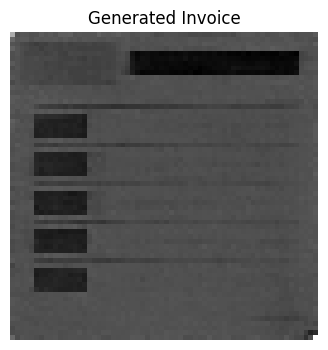

In [6]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

# Re-define necessary global variables and classes/functions
# from KlNnmml_DUhZ
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HPARAMS = {
    "img_size": 64,
    "timesteps": 500,
    "batch_size": 32,
    "lr": 3e-4,
    "epochs": 10,
    "channels": 1,
    "num_classes": 3
}

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = np.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()

    def forward(self, x, t):
        h = self.bnorm1(self.relu(self.conv1(x)))
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[(..., ) + (None, ) * 2]
        h = h + time_emb
        h = self.bnorm2(self.relu(self.conv2(h)))
        return self.transform(h)

class ConditionalUNet(nn.Module):
    def __init__(self):
        super().__init__()
        img_channels = HPARAMS["channels"]
        down_channels = (32, 64, 128)
        up_channels = (128, 64, 32)
        out_dim = img_channels
        time_emb_dim = 32
        classes = HPARAMS["num_classes"]

        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )
        self.class_emb = nn.Embedding(classes, time_emb_dim)
        self.conv0 = nn.Conv2d(img_channels, down_channels[0], 3, padding=1)
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], time_emb_dim) for i in range(len(down_channels)-1)])
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], time_emb_dim, up=True) for i in range(len(up_channels)-1)])
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep, class_label):
        t = self.time_mlp(timestep)
        c = self.class_emb(class_label)
        t = t + c
        x = self.conv0(x)
        residuals = []
        for down in self.downs:
            x = down(x, t)
            residuals.append(x)
        for up in self.ups:
            residual = residuals.pop()
            x = torch.cat((x, residual), dim=1)
            x = up(x, t)
        return self.output(x)

# from BVsgcf64Cm9I
class DiffusionManager:
    def __init__(self, timesteps=500, start=0.0001, end=0.02):
        self.timesteps = timesteps
        self.betas = torch.linspace(start, end, timesteps).to(device)
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)

    def forward_noise(self, x_0, t):
        noise = torch.randn_like(x_0)
        sqrt_alpha_bar_t = self.sqrt_alphas_cumprod[t][:, None, None, None]
        sqrt_one_minus_alpha_bar_t = self.sqrt_one_minus_alphas_cumprod[t][:, None, None, None]
        return sqrt_alpha_bar_t * x_0 + sqrt_one_minus_alpha_bar_t * noise, noise

    @torch.no_grad()
    def sample(self, model, n_samples, class_label_idx, size):
        model.eval()
        x = torch.randn((n_samples, 1, size, size)).to(device)
        labels = torch.full((n_samples,), class_label_idx, dtype=torch.long).to(device)
        for i in reversed(range(1, self.timesteps)):
            t = (torch.ones(n_samples) * i).long().to(device)
            predicted_noise = model(x, t, labels)
            alpha = self.alphas[t][:, None, None, None]
            alpha_hat = self.alphas_cumprod[t][:, None, None, None]
            beta = self.betas[t][:, None, None, None]
            if i > 1:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)
            x = (1 / torch.sqrt(alpha)) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        model.train()
        return x

# from YYmF8sCdP3QP
def load_model(filename="fintech_diffusion_model.pth"):
    """Creates a new model instance and loads weights."""
    if not os.path.exists(filename):
        print(f"❌ Error: {filename} not found.")
        return None

    model = ConditionalUNet().to(device)
    model.load_state_dict(torch.load(filename, map_location=device))
    model.eval()
    print(f"✅ Model loaded from {filename}")
    return model

def generate_single_document(model, diffusion, doc_type='invoice'):
    """Generates a single image of the requested type."""
    label_map = {'invoice': 0, 'receipt': 1, 'chart': 2}

    if doc_type not in label_map:
        print(f"❌ Unknown type: {doc_type}. Use 'invoice', 'receipt', or 'chart'")
        return

    print(f"🎨 Generating new {doc_type}...")
    sample_tensor = diffusion.sample(model, n_samples=1, class_label_idx=label_map[doc_type], size=HPARAMS["img_size"])

    # Convert tensor to displayable image
    img = sample_tensor[0].cpu().permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min()) # Normalize to 0-1

    plt.figure(figsize=(4,4))
    plt.imshow(img, cmap='gray')
    plt.title(f"Generated {doc_type.capitalize()}")
    plt.axis('off')
    plt.show()

# Load the model back
loaded_model = load_model("fintech_diffusion_model.pth")

# Initialize DiffusionManager for sampling
# This requires HPARAMS and device to be defined
diff_manager = DiffusionManager(timesteps=HPARAMS["timesteps"])

# Generate a specific new document
generate_single_document(loaded_model, diff_manager, doc_type='invoice')